In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set all the constants
beta = 0.96       
alpha = 0.25      
A = (alpha * beta)**(-1)  
sigma = 0.5       
n = 41            
m = 41            
eps = 1e-5        

# Discretize k
k_min = 0.0875
k_max = 3.5875
k_grid = np.linspace(k_min, k_max, n)

# Discretize z
z_min = -3 * sigma
z_max = 3 * sigma
z_grid = np.linspace(z_min, z_max, m)

In [3]:
# Making probabiltiy functions to call later
def normal_pdf(x, mean=0, std=sigma):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)

q = np.array([normal_pdf(z) for z in z_grid])
q /= q.sum() 

# Prod and Util func to call later
def utility(c):
    return np.log(c)
    
def production(k, z):
    return A * np.exp(z) * k**alpha

In [4]:
# Value function iteration
def value_function_iteration(k_grid, z_grid, q, beta, eps):
    
    V = np.zeros((n, m))  
    
    # Just in case it doesn't converge
    max_iter = 1000
    for iter in range(max_iter):
        V_new = np.zeros((n, m))
        for i in range(n):  
            for j in range(m): 
                max_value = -np.inf
                for ip in range(n):
                    c = production(k_grid[i], z_grid[j]) - k_grid[ip]
                    if c <= 0:
                        continue  # Skip invalid consumption
                    EV = 0
                    for jp in range(m):
                        EV += q[jp] * V[ip, jp]
                    value = utility(c) + beta * EV
                    if value > max_value:
                        max_value = value
                V_new[i, j] = max_value
        
        # Check for convergence
        diff = np.max(np.abs(V_new - V))
        if diff < eps:
            print(f"Converged after {iter + 1} iterations.")
            break
        V = V_new.copy()
    return V
# Very bad implementation using loops, vectorization needed later but i'm lazy

In [5]:
V_star = value_function_iteration(k_grid, z_grid, q, beta, eps)

Converged after 287 iterations.


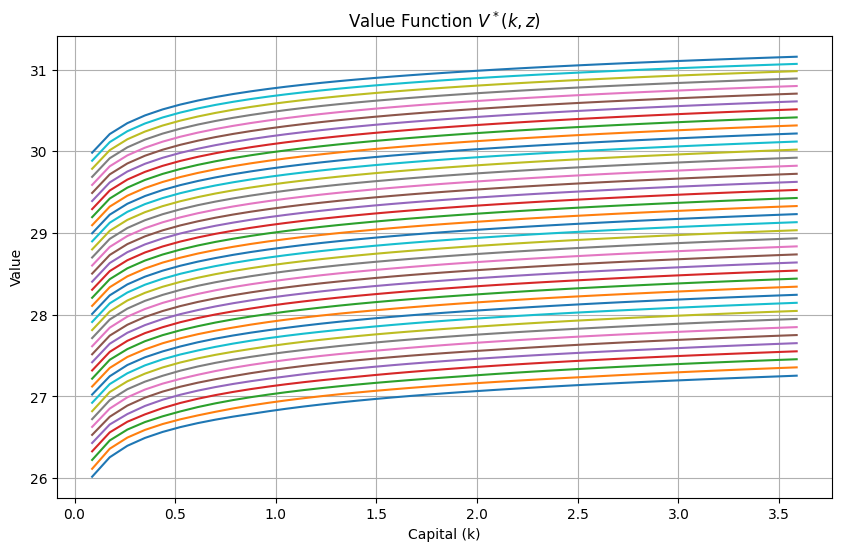

In [7]:
plt.figure(figsize=(10, 6))
for j in range(m):
    plt.plot(k_grid, V_star[:, j], label=f'z = {z_grid[j]:.2f}')
plt.title("Value Function $V^*(k, z)$")
plt.xlabel("Capital (k)")
plt.ylabel("Value")
plt.grid(True)
plt.show()

Concave value functions, which are expected indicating that the code seems to work.

In [12]:
# Policy functions to get a vector of policy matrices
def policy_function(k_grid, z_grid, q, V_star, beta):

    policy = np.zeros((n, m, n))  
    
    # Loop over all (k, z) pairs
    for i in range(n):  
        for j in range(m):  
            max_value = -np.inf
            best_ip = 0  
            for ip in range(n):
                c = production(k_grid[i], z_grid[j]) - k_grid[ip]
                if c <= 0:
                    continue  
                EV = 0
                for jp in range(m):
                    EV += q[jp] * V_star[ip, jp]
                value = utility(c) + beta * EV
                if value > max_value:
                    max_value = value
                    best_ip = ip
            policy[i, j, best_ip] = 1
    
    return policy

policy = policy_function(k_grid, z_grid, q, V_star, beta)

print(policy[:2, :2, :2])  

[[[1. 0.]
  [0. 1.]]

 [[0. 1.]
  [0. 1.]]]


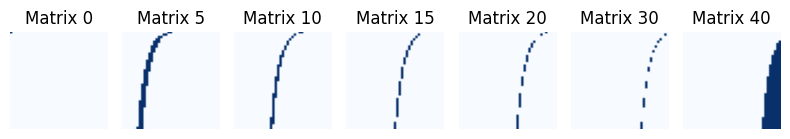

In [14]:
selected_indices = [0,5,10,15,20,30,40]
fig, axes = plt.subplots(1, len(selected_indices), figsize=(8, 4))

for i, idx in enumerate(selected_indices):
    ax = axes[i] if len(selected_indices) > 1 else axes
    ax.imshow(policy[:, :, idx], cmap='Blues')  # Use 'Blues' or any color scheme
    ax.set_title(f'Matrix {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Above we plot some of the policy functions we have found for some shock values. From the $\mathbb{R^3}$ space of the $P$.

Converged after 7 iterations.


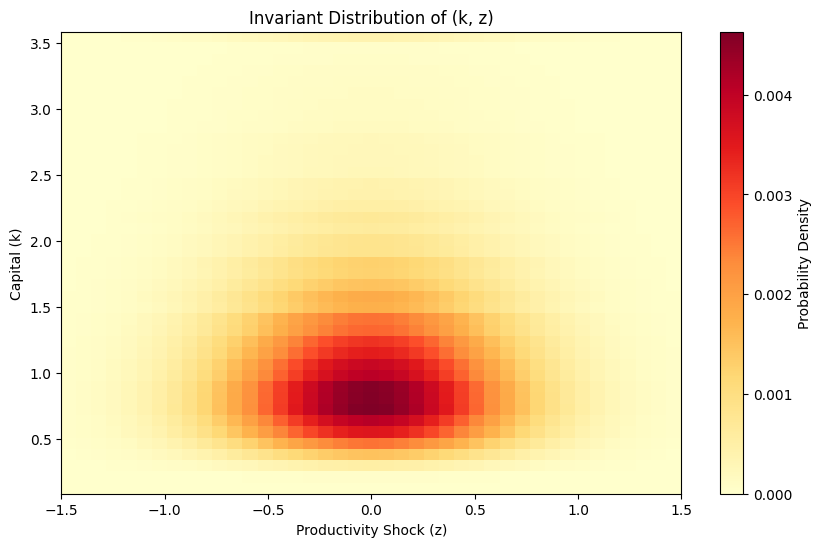

In [15]:
def compute_transition_matrix(k_grid, z_grid, policy, q):
    n = len(k_grid)
    m = len(z_grid)
    nm = n * m
    # Intialise this matrix
    Pi = np.zeros((nm, nm))
    # Fill the transition matrix
    for i in range(n):  # Current capital k_i
        for j in range(m):  # Current productivity z_j
            # Find the optimal k' index from the policy function
            optimal_ip = np.argmax(policy[i, j, :])
            # Transition probabilities for the next z state
            for jp in range(m):
                # Index in the flattened state space
                current_state = i * m + j
                next_state = optimal_ip * m + j
                Pi[current_state, next_state] = q[jp]
    return Pi
# Tried to do it slightly differntly, to consider directly the transition from todays k/z to the k',z' for tommorow

def compute_invariant_distribution(Pi, eps=1e-5, max_iter=1000):
    nm = Pi.shape[0]
    xi = np.ones(nm) / nm
    # Just gonna iterate this till converge
    for iter in range(max_iter):
        xi_next = xi @ Pi  
        # Check for convergence
        diff = np.linalg.norm(xi_next - xi)
        if diff < eps:
            print(f"Converged after {iter + 1} iterations.")
            break
        xi = xi_next
    return xi

# Get the matrix to go from any k,z to k',z'
Pi = compute_transition_matrix(k_grid, z_grid, policy, q)

# Compute the invariant distribution
xi = compute_invariant_distribution(Pi)
# Reshape the list of all combos to fit into the state variable space
xi_reshaped = xi.reshape((n, m))

# Plot as a heatmap (I like heat maps)
plt.figure(figsize=(10, 6))
plt.imshow(xi_reshaped, cmap="YlOrRd", origin="lower", aspect="auto", 
           extent=[z_grid[0], z_grid[-1], k_grid[0], k_grid[-1]])
plt.colorbar(label="Probability Density")
plt.title("Invariant Distribution of (k, z)")
plt.xlabel("Productivity Shock (z)")
plt.ylabel("Capital (k)")
plt.show()

Above plots the invariant distribution in the $\mathbb{R^2}$ space for the state variables.

For the final part we know because of the indepedence condition, that the above distribution applies to all nations hence we can leverage this to help find a solution.

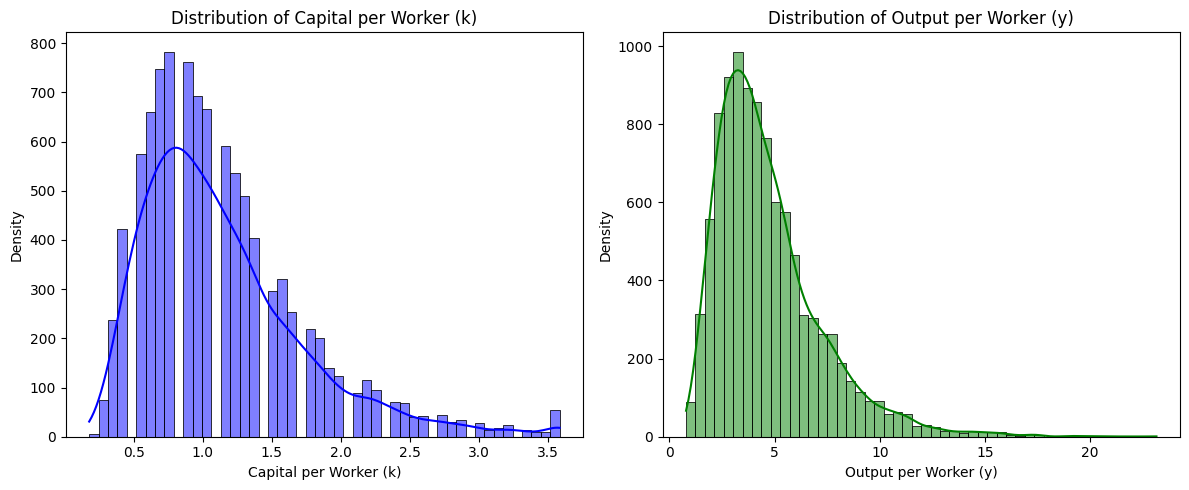

In [20]:
import seaborn as sns

num_countries = 10000
# Sample from the dist
indices = np.random.choice(n * m, size=num_countries, p=xi)
k_indices = indices // m
z_indices = indices % m

# get the values form the discrete ones
k_simulated = k_grid[k_indices]
z_simulated = z_grid[z_indices]

# Putting into the def of output
y_simulated = np.exp(z_simulated) * A * k_simulated**alpha

# Plot the distribution of capital per worker
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(k_simulated, bins=50, kde=True, color="blue")
plt.title("Distribution of Capital per Worker (k)")
plt.xlabel("Capital per Worker (k)")
plt.ylabel("Density")

# Plot the distribution of output per worker
plt.subplot(1, 2, 2)
sns.histplot(y_simulated, bins=50, kde=True, color="green")
plt.title("Distribution of Output per Worker (y)")
plt.xlabel("Output per Worker (y)")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

# Get gaps in capital for some reason, maybe just need to clean up the division above (prob just the way its linear spaced)

We may conclude that for this model the capital per worker is what really matters for outcome seeing the correspondence between them.

Looking above at the heatmap for the distribution this isn't really, a surprise as taking a slice through the middle is skewed like above. And as the sample size is large we get close to that 'middle slice' of the distibution.